In [1]:
from astropy import constants as const
from astropy import units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import trapz
import scipy.integrate as integrate
from scipy.optimize import curve_fit 
from scipy.optimize import leastsq
import random

### Punto 1
Guardamos primero cada distancia en una lista con sus unidades respectivas:

In [2]:
d=[]
d.append(150e6*u.km)
d.append(7.9*u.kpc)
d.append(50*u.kpc)
d.append(14*u.Mpc)
d.append(53*u.Mpc)
d.append(113*u.Mpc)

Guardamos en otra lista el tiempo que demora la luz en recorrer las distancias hasta la tierra. Lo anterior teniendo en cuenta la velocidad de la luz en el vacío y las unidades:

In [3]:
t=[]
for i in range(len(d)):
    if d[i].unit=="km":
        t.append(d[i]/const.c.to(u.km/u.s))
    if d[i].unit=="kpc":
        t.append(d[i]/const.c.to(u.kpc/u.s))
    if d[i].unit=="Mpc":
        t.append(d[i]/const.c.to(u.Mpc/u.s))

Estos tiempos están en segundos, procedamos a convertir cada tiempo a unidades más apreciables:

In [4]:
for i in range(len(t)):
    if i==0:
        t[0]=t[0].to(u.min)
    else:
        t[i]=t[i].to(u.yr)

Mostramos los resultados en una tabla:

In [5]:
tab=pd.DataFrame(t,['Desde el sol','Desde el centro de la vía Láctea','Desde la gran nube de magallanes',\
                    'Desde la galaxia NGC 4649','Desde el cúmulo de galaxias de Pegaso', \
                    'Desde el cúmulo de Leo'],['Tiempo-luz'])
tab.head()

,Tiempo-luz
Desde el sol,8.3391023799538 min
Desde el centro de la vía Láctea,25766.353839420848 yr
Desde la gran nube de magallanes,163078.18885709395 yr
Desde la galaxia NGC 4649,45661892.87998632 yr
Desde el cúmulo de galaxias de Pegaso,172862880.18851966 yr


### Punto 2
Por las condiciones dadas supongamos que $$y=mx$$
Para el ajuste la idea sería minimizar $S(m)$:
$$S(m)=\sum_{i=0}^n(y_i-mx_i)^2=\sum_{i=0}^n(y_i^2-2y_imx_i+m^2x_i^2)$$
El óptimo de $m$ vendría dado por:
$$\frac{dS}{dm}=\sum_{i=0}^n-2(y_ix_i-mx_i^2)=2\left(m\sum_{i=0}^nx_i^2-\sum_{i=0}^ny_ix_i\right)=0 \implies m\sum_{i=0}^nx_i^2-\sum_{i=0}^ny_ix_i=0 \implies m=\frac{\sum_{i=0}^ny_ix_i}{\sum_{i=0}^nx_i^2}$$

### Punto 3
Ingresamos primero los datos de [Hubble](https://www.pnas.org/content/pnas/15/3/168.full.pdf?guid=on):

In [6]:
d=np.array([0.032,0.034,0.214,0.263,0.275,0.275,0.45,0.5,0.5,0.63,0.8,0.9,0.9,0.9,0.9,1,1.1,1.1,1.4,1.7,2,2,\
           2,2])
v=np.array([170,290,-130,-70,-185,-220,200,290,270,200,300,-30,650,150,500,920,450,500,500,960,500,850,800,\
           1090])

Calculamos ahora la pendiente de la recta ajustada a los datos anteriores de la forma $y=mx$, usando el punto anterior:

In [7]:
num=0
den=0
for i in range(len(d)):
    num+=d[i]*v[i]
    den+=d[i]**2
m=num/den

Grafiquemos ahora los datos anteriores junto con la recta ajustada a los mismos:

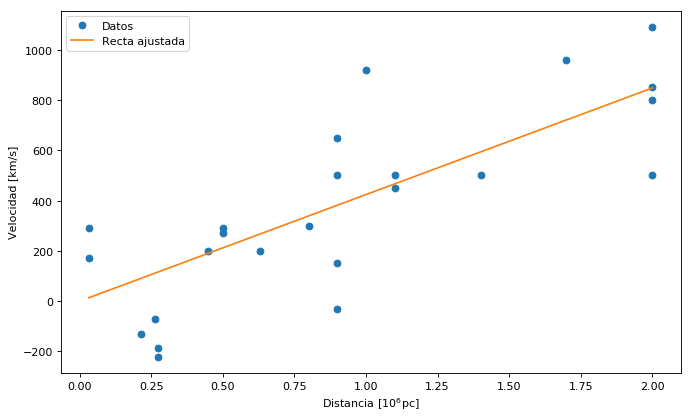

In [8]:
def f(x):
    return m*x
x=np.linspace(d.min(),d.max(),50)
y=np.zeros(len(x))
for i in range(len(x)):
    y[i]=f(x[i])
plt.figure(figsize=(10,6), dpi=80)
plt.plot(d,v,'o',x,y,'-')
plt.xlabel(r'Distancia [$10^6$pc]')
plt.ylabel('Velocidad [km/s]')
plt.legend(('Datos','Recta ajustada'),loc=0)
plt.show()

Obtengamos ahora $H_0$ en las unidades pedidas:

In [9]:
m=m*(u.km/(u.s*1e6*u.pc))
M=m.to(u.km/(u.s*u.Mpc))
M

<Quantity 423.93732323 km / (Mpc s)>

### Punto 4
Note que $\displaystyle t_0=\frac{1}{H_0}$, así el tiempo de Hubble será:

In [10]:
1/M.to(u.km/(u.s*u.km))

<Quantity 7.27861741e+16 s>

In [11]:
(1/M.to(u.km/(u.s*u.km))).to(u.yr).value

2306454676.41188

### Punto 5


Ingresemos primero los datos de la información dada:

In [12]:
tab=pd.read_csv("data.csv")
dat=tab.values
dat[:5]

array([['1993ah\t0.028488\t35.3465833928\t0.223905932998\t0.128418942246'],
       ['1993ag\t0.050043\t36.6823679154\t0.166828851413\t0.128418942246'],
       ['1993o\t0.052926\t36.8176912545\t0.1557559148\t0.128418942246'],
       ['1993b\t0.070086\t37.4467365424\t0.158466934433\t0.128418942246'],
       ['1992bs\t0.062668\t37.4834093505\t0.156099434739\t0.128418942246']],
      dtype=object)

Limpiemos los datos y tomamos la información pedida:

In [13]:
rojo=[]
mod=[]
er=[]
for i in range(len(dat)):
    c1,c2,c3,c4,c5=dat[i][0].split("\t")
    rojo.append(float(c2))
    mod.append(float(c3))
    er.append(float(c4))

print("Corrimiento al rojo:",rojo[:3],"...",rojo[len(rojo)-3:len(rojo)])
print("Módulo de distancia:",mod[:2],"...",mod[len(mod)-2:len(mod)])
print("Error:",er[:3],"...",er[len(mod)-3:len(mod)])

Corrimiento al rojo: [0.028488, 0.050043, 0.052926] ... [0.821, 1.215, 0.623]
Módulo de distancia: [35.3465833928, 36.6823679154] ... [45.2465209495, 42.5145239973]
Error: [0.223905932998, 0.166828851413, 0.1557559148] ... [0.194013591972, 0.560317445151, 0.241428134977]


Obtenemos $v$ y $D_L$ teniendo en cuenta que $v=zc$ y $D_L=10^{\frac{\mu}{5}-5}$:

In [14]:
d=[]
v=[]
for i in range(len(mod)):
    d.append(10**((mod[i]/5)-5))
    v.append(rojo[i]*const.c.value)

Graficamos los datos obtenidos:

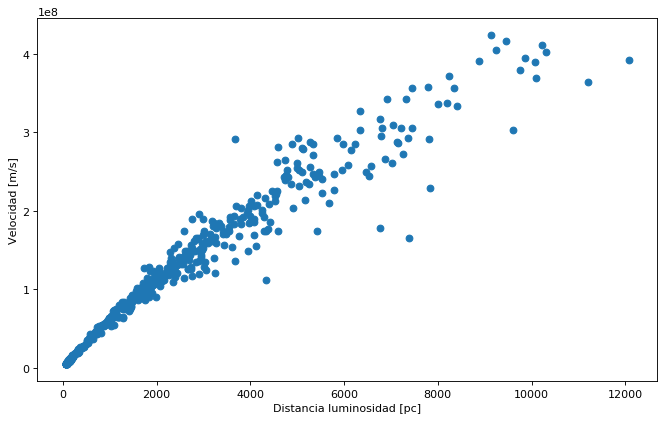

In [15]:
plt.figure(figsize=(10,6), dpi=80)
plt.plot(d,v,'o')
plt.xlabel('Distancia luminosidad [pc]')
plt.ylabel('Velocidad [m/s]')
plt.show()

De la gráfica podemos notar que hasta cierta distancia los datos parecen tener un comportamiento lineal de acuerdo con la ley de Hubble-Lemaitre, la idea ahora es encontrar dicha distancia. Para ello, ajustemos los datos a una recta de la forma $v=mD_L$: considerando primero los tres primeros valores de $D_L$, después los cuatro primeros valores de $D_L$, luego los cinco primero valores de $D_L$ y así sucesivamente. Lo anterior para registrar los valores de $m$, $(v_i-mD_{L_i})^2$ y $\sigma_i$ a medida que consideramos las primeras $i$-ésimas distancias hasta considerar todas.

Primero ordenemos los datos de distancia, velocidad y error en orden ascendente:

In [16]:
a=np.sort(d)
b=[]
c=[]
for i in range(len(a)):
    b.append(v[d.index(a[i])])
    c.append(er[d.index(a[i])])
d.sort()
v=b
er=c

Guardemos ahora en las listas $\mathtt{std},\mathtt{r} \ \text{y} \ \mathtt{\text{H_0}}$ la desviación estántar, el máximo de los residuales y la pendiente de la recta ajustada, respectivamente; para cada ajuste hasta la $i$-ésima distancia considerada:

In [17]:
def f(x,m):
    return m*x
r=[99999999999999,999999999999999]
H_0=r.copy()
for i in range(3,len(d)+1):
    D=d[:i]
    V=v[:i]
    popt,pcov=curve_fit(f,D,V)
    M=popt[0]
    H_0.append(M)
    
    res=[]
    for j in range(len(D)):
        res.append((V[j]-M*D[j])**2)
    r.append(np.max(res))

Ahora gráficamente veamos los distintos valores de $H_0$ arrojados por cada ajuste para todos los datos (gráfico en la parte superior derecha). La idea es poner atención en aquellas distancias en las cuales se observe un comportamiento constante de $H_0$, en particular consideramos las distancias entre 220pc y 310pc (gráficos restantes):

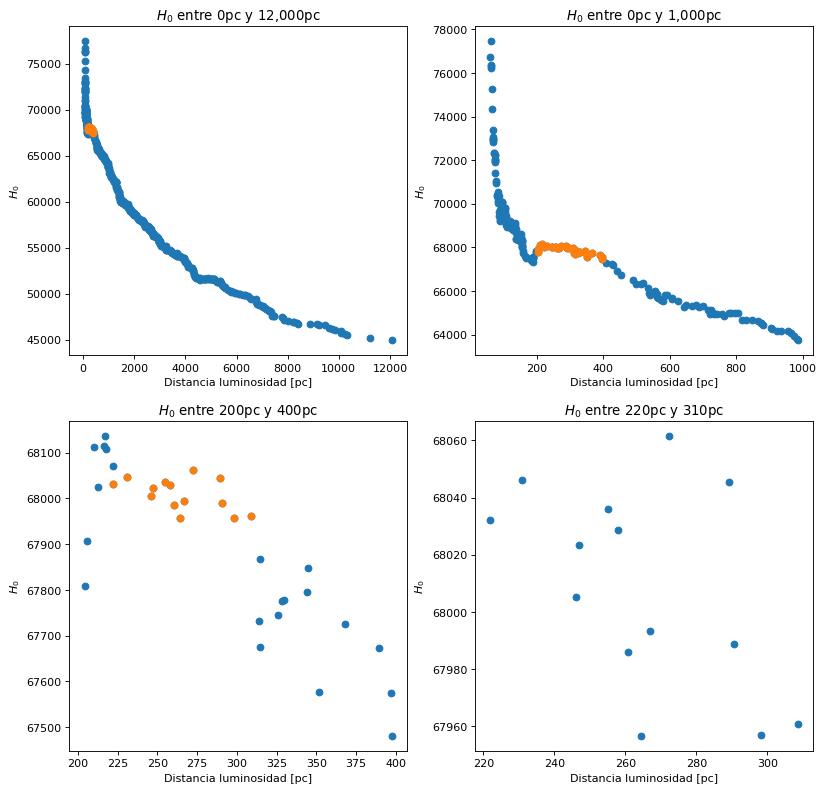

In [18]:
plt.figure(figsize=(12,12), dpi=80)

plt.subplot(221)
plt.plot(d[2:],H_0[2:],'o',d[135:170],H_0[135:170],'o')
plt.xlabel('Distancia luminosidad [pc]')
plt.ylabel(r'$H_0$')
plt.title(r'$H_0$ entre 0pc y 12,000pc')

plt.subplot(222)
plt.plot(d[2:230],H_0[2:230],'o',d[135:170],H_0[135:170],'o')
plt.xlabel('Distancia luminosidad [pc]')
plt.ylabel(r'$H_0$')
plt.title(r'$H_0$ entre 0pc y 1,000pc')

plt.subplot(223)
plt.plot(d[135:170],H_0[135:170],'o',d[143:157],H_0[143:157],'o')
plt.xlabel('Distancia luminosidad [pc]')
plt.ylabel(r'$H_0$')
plt.title(r'$H_0$ entre 200pc y 400pc')

plt.subplot(224)
plt.plot(d[143:157],H_0[143:157],'o')
plt.xlabel('Distancia luminosidad [pc]')
plt.ylabel(r'$H_0$')
plt.title(r'$H_0$ entre 220pc y 310pc')

plt.show()

No consideramos las distancias entre 4,000pc y 6,000pc pues aunque $H_0$ parezca tener un comportamiento constante los residuales de los ajustes en estas distancias son mayores en comparación con distancias anteriores; también porque del gráfico de $v$ vs $D_L$ podíamos notar que después de 2,000pd los datos tendían a comportarse de una forma "menos" lineal. 

Para saber hasta que distancia entre 220pc y 310pc es válida la ley de Hubble-Lemaitre, consideremos el máximo de los residuales de los ajustes hasta cada distancia en ese intervalo:

In [19]:
print("Distancia         H_0       Máx. Residual cuadrático")
for i in range(143,157):
    print('{:f}'.format(d[i]),"  ",'{:f}'.format(H_0[i]),"  ",'{:f}'.format(r[i]))

Distancia         H_0       Máx. Residual cuadrático
221.982879    68032.007178    7151200729080.991211
230.960787    68046.240166    7136184008502.704102
245.972798    68005.053605    7179681732929.936523
247.015732    68023.417735    7160270781918.681641
254.991694    68035.991251    7146995683803.875000
258.022530    68028.783702    7154603895284.847656
260.646160    67985.975764    7199874904958.107422
264.441433    67956.660769    7230958983309.403320
266.808030    67993.270628    7192150219654.280273
272.333109    68061.411398    7120194757885.896484
289.293156    68045.353381    7137119163057.625977
290.528219    67988.865858    7196814027946.750000
298.140524    67957.010094    7230588182565.770508
308.565458    67960.840502    7226522921695.465820


Escogemos como distancia límite para la validez de la ley de Hubble-Lemaitre 272.331pc pues es en esa distancia que es minímo el máximo de los residuales del ajuste lineal. Obtengamos ahora $H_0$ haciendo un ajuste lineal hasta dicha distancia teniendo en cuenta el error en las mediciones. Así,

$$S(H_0)=\sum_{i=0}^nW_i^2(v_i-H_0d_i)^2$$
Dado que se quiere minimizar $S(H_0)$:
$$H_0=\frac{\sum_{i=0}^nW_i^2v_id_i}{\sum_{i=0}^nW_i^2d_i^2}$$
Donde:
$$W_i=\frac{1}{\sigma} \qquad \sigma=\frac{d}{d\mu}\left[10^{\frac{\mu}{5}-5}\right]\sigma_\mu=\left[10^{\frac{\mu}{5}-5}\frac{\ln(10)}{5}\right]\sigma_\mu$$
Reemplazando los datos en las fórmulas anteriores tenemos:

In [20]:
e=[]
for i in range(len(er)):
    e.append((10**((mod[i]/5)-5))*(np.log(10)/5)*er[i])

num=0
den=0
for i in range(len(e[:153])):
    num+=((1/e[i])**2)*d[i]*v[i]
    den+=((1/e[i])**2)*d[i]**2
H_0=num/den
(H_0/1000)*(u.km/(u.s*u.Mpc))

<Quantity 68.09990643 km / (Mpc s)>

Note que este valor de $H_0$ se encuentra dentro del rango de valores aceptado/discutido por la cosmología en la actualidad.

### Punto 6
Definamos primero la función dada

In [21]:
def mu(v,H):
    return (5*np.log10(v/H))+25

Realicemos el ajuste hasta la distancia determinada anteriormente tomando a $\mathtt{H}$ como el único parámetro libre:

In [22]:
mod=(5*np.log10(d))+25
h,a=curve_fit(mu,v[:153],mod[:153])
(h[0]/1000)*(u.km/(u.s*u.Mpc))

<Quantity 68.27944043 km / (Mpc s)>

Note que los resultados anteriores coinciden en la parte entera y sólo difieren en las cifras decimales.

### Punto 7
Definimos primero la función a integrar:

In [23]:
def f(z):
    return 1/np.sqrt((omega_m*((1+z)**3))+omega_a+((1-omega_m-omega_a)*((1+z)**2)))

Definimos ahora una función que calcule el número de regiones óptimas para que la integral varíe en menos de 0.01% respecto al caso anterior:

In [24]:
def trap(f,a,b,tol=1.0e-4):
    
    def sep(f,a,b,n):
        "Separa el intervalo (a,b) en n regiones, calcula además f(x) para todos los x en (a,b)."
        x=np.linspace(a,b,n+1)
        y=[]
        for i in range(len(x)):
            y.append(f(x[i]))
        return x,y

    x,y=sep(f,a,b,1)
    I0=trapz(y,x)
    for i in range(2,50001):
        x,y=sep(f,a,b,i)
        I1=trapz(y,x)
        if abs(I1-I0) < tol*max(abs(I1),1.0):
            return I1,i
        I0=I1
    print("La regla del trapecio no converge")

Integramos primero para $z=1.4$, $\Omega_M=1$ y $\Omega_\Lambda=0$:

In [25]:
omega_m=1
omega_a=0
I,n=trap(f,0,1.4)
print("Aproximadamente la integral definida es igual a",I,"y se necesitaron",n,\
      "regiones para llegar a la precisión deseada.")

Aproximadamente la integral definida es igual a 0.7097574796763606 y se necesitaron 17 regiones para llegar a la precisión deseada.


Integramos ahora para $z=1.4$, $\Omega_M=0.3$ y $\Omega_\Lambda=0.7$:

In [26]:
omega_m=0.3
omega_a=0.7
I,n=trap(f,0,1.4)
print("Aproximadamente la integral definida es igual a",I,"y se necesitaron",n,\
      "regiones para llegar a la precisión deseada.")

Aproximadamente la integral definida es igual a 0.9750400987802947 y se necesitaron 10 regiones para llegar a la precisión deseada.


### Punto 8
Comenzemos por definir las funciones necesarias para graficar, empezando con la distancia luminosidad:

In [27]:
def D_L(z,omega_m,omega_a):
    def f(x):
        return 1/np.sqrt((omega_m*((1+x)**3))+omega_a+((1-omega_m-omega_a)*((1+x)**2)))
    I=integrate.quad(f,0,z)[0]
    omega_k=1-omega_m-omega_a
    if omega_m+omega_a>1:
        return ((1+z)*const.c.value*np.sin(np.sqrt(np.abs(omega_k))*I))/(H_0*np.sqrt(np.abs(omega_k)))
    if omega_m+omega_a==1:
        return ((1+z)*const.c.value*I)/H_0
    if omega_m+omega_a<1:
        return ((1+z)*const.c.value*np.sinh(np.sqrt(np.abs(omega_k))*I))/(H_0*np.sqrt(np.abs(omega_k)))

Y continuando con el modulo de distancia:

In [28]:
def Mod(z,omega_m,omega_a):
    return (5*np.log10(D_L(z,omega_m,omega_a)))+25

Calculemos ahora los valores de $\mu$ para los distintos modelos:

In [29]:
mu_1=[]
mu_2=[]
mu_3=[]
mu_4=[]
x=np.linspace(np.min(rojo),np.max(rojo),50)
for i in range(len(x)):
    mu_1.append(Mod(x[i],1,0))
    mu_2.append(Mod(x[i],0.2,0))
    mu_3.append(Mod(x[i],2,0))
    mu_4.append(Mod(x[i],0.3,0.7))

Graficamos $z$ y $\mu$ para todas las supernovas dadas junto con los modelos:

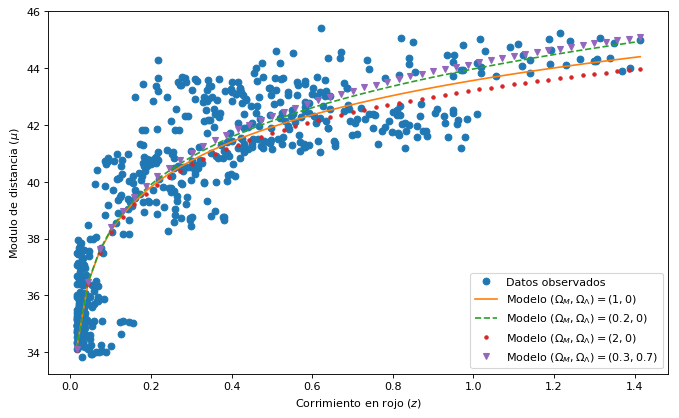

In [30]:
plt.figure(figsize=(10,6), dpi=80)
plt.plot(rojo,mod,'o',x,mu_1,'-',x,mu_2,'--',x,mu_3,'.',x,mu_4,'v')
plt.ylabel(r'Modulo de distancia ($\mu$)')
plt.xlabel(r'Corrimiento en rojo ($z$)')
plt.legend(('Datos observados',r'Modelo $(\Omega_M,\Omega_\Lambda)=(1,0)$',r'Modelo \
$(\Omega_M,\Omega_\Lambda)=(0.2,0)$',r'Modelo $(\Omega_M,\Omega_\Lambda)=(2,0)$',r'Modelo \
$(\Omega_M,\Omega_\Lambda)=(0.3,0.7)$',),loc=0)
plt.show()

A partir del gráfico podemos decir que en general ningún modelo produce un mal ajuste a los datos pues todos se comportan de forma similar. Sin embargo, podríamos decir que el modelo que mejor se ajusta a los datos es el modelo $(\Omega_M,\Omega_\Lambda)=(0.3,0.7)$. Para corroborar esto, calculemos el promedio,los minímos y máximos de los residuos cuadráticos de cada modelo:

In [31]:
r1=[]
r2=[]
r3=[]
r4=[]

for i in range(len(rojo)):
    r1.append((mod[i]-Mod(rojo[i],1,0))**2)
    r2.append((mod[i]-Mod(rojo[i],0.2,0))**2)
    r3.append((mod[i]-Mod(rojo[i],2,0))**2)
    r4.append((mod[i]-Mod(rojo[i],0.3,0.7))**2)
    
r_min=[np.min(r1),np.min(r2),np.min(r3),np.min(r4)]
r_max=[np.max(r1),np.max(r2),np.max(r3),np.max(r4)]
r_m=[np.mean(r1),np.mean(r2),np.mean(r3),np.mean(r4)]

Notando como modelo 1 al modelo $(\Omega_M,\Omega_\Lambda)=(1,0)$, con modelo 2 al modelo 
$(\Omega_M,\Omega_\Lambda)=(0.2,0)$, con modelo 3 al modelo $(\Omega_M,\Omega_\Lambda)=(2,0)$ y con modelo 4 
al modelo $(\Omega_M,\Omega_\Lambda)=(0.3,0.7)$, tenemos:

In [32]:
print("Modelo  Min. Residual cuadrático  Máx. Residual cuadrático  Prom. Residual cuadrático")
for i in range(len(r_min)):
    print("  ",i+1,"           ",'{:f}'.format(r_min[i]),"               ",'{:f}'.format(r_max[i]),\
         "                ",'{:f}'.format(r_m[i]))

Modelo  Min. Residual cuadrático  Máx. Residual cuadrático  Prom. Residual cuadrático
   1             0.000007                 18.232808                  2.003536
   2             0.000002                 18.338250                  1.999858
   3             0.000116                 19.128044                  2.083626
   4             0.000000                 19.116454                  2.022052


De los calculos anterior podemos decir que el modelo que mejor se ajusta a los datos es el modelo $(\Omega_M,\Omega_\Lambda)=(2,0)$ ya que cuenta con el menor minímo residual cuadrático, el menor máximo residual cuadrático y el menor promedio de los residuales cuadráticos.

### Punto 9

In [33]:
def f_err(omega,rojo,mod,er):
    omega_m=omega[0]
    omega_a=omega[1]
    if (omega_m>1 or omega_m<0) or (omega_a>1 or omega_a<0):
        return 99999999999999999999999999999999999999999999999999999
    else:
        return (mod-Mod(rojo,omega_m,omega_a))/er

def Min(a,b):
    x_0=(a,b)
    omega,c=leastsq(f_err,x_0,args=(rojo,mod,er))
    return omega

In [34]:
a=random.uniform(-5,5)
b=random.uniform(-5,5)
print(a,b,Min(a,b))

TypeError: Improper input: N=2 must not exceed M=1

In [35]:
x=np.array([1.0,2.5,3.5,4.0,1.1,1.8,2.2,3.7])
y=np.array([6.008,15.722,27.130,33.772,5.257,9.549,11.098,28.828])
def ErrorFunc(tpl,x,y):
    return (tpl[0]*x)+tpl[1]-y
tplInitial1=(1.0,2.0)
tplFinal1,success=leastsq(ErrorFunc,tplInitial1[:],args=(x,y))
print(" linear fit ",tplFinal1)

 linear fit  [ 9.43854354 -6.18989527]


In [36]:
def f(x,m,b):
    return (m*x)+b
p,c=curve_fit(f,x,y)
p

array([ 9.43854354, -6.18989526])